<h2>DATA 620 - Web Analytics - Final Project</h2>
<h3>Team : Mohamed Thasleem, Kalikul Zaman and Jeyaraman Ramalingam</h3>
<h3>Introduction</h3>
    
Build an sentiment analysis from popular twitter account and analyze possible network analysis with multiple twitter accounts

We considered the following leader twitter account and perform sentiment analysis, also to build network graph specific to Donald Trump
<ol>
  <li>Donald Trump</li>
  <li>Emmanuel Macron</li>
  <li>Angela Merkel</li>
  <li>Narendra Modi</li>
  <li>Boris Johnson</li>
</ol>
   
<h3>Analysis Overview</h3>
<ol>
  <li>Loading the dataset: Load the data and import the libraries.</li>
  <li>Data Preprocessing (Analysing missing data and removing redendant columns)</li>
  <li>Visualising and counting sentiments of tweets for each airline</li>
  <li>Wordcloud plots for positive and negative tweets to visualise most frequent words for each.</li>
  <li>Analysing the reasons for tweets for each leader Sentiment analysis VANDER and text blob approach</li>
  <li>Predicting the tweet sentiments with tweet text data and comapare with multiple classifer models</li>
  <li>Calculating accuracies of the models</li>
  <li>Buliding Network Graph for Trump</li>
  <li>Conclusion</li>
</ol>



<h3>Importing the libraries</h3>

In [1]:
#Import Libraries
import tweepy 
import pandas as pd
import sys
import csv
import matplotlib.pyplot as plt
import re
import twitter
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import networkx as nx
from pandasql import sqldf
pd.set_option('display.max_columns', None)

<h3>Declaring Functions required for this Project</h3>

get_tweets - API to fetch the tweets<br>
tweet_to_words - convert tweets to words<br>
generate_wordcloud - Wordcloud generation using cleaned text<br>
clean_tweet_length - Perform cleansing on tweets to pick only letters<br>
clean_dataframe - Perform cleansing to elimiate junk words<br>
predict_accuracy - Calcualte the accuracy using multiple model classifier<br>
vader_sentiment - Function to perform VANDER sentiment<br>
textblob_sentiment - Function to perform textblob sentiment<br>



In [29]:
def get_tweets(username): 
        auth = tweepy.OAuthHandler('uiFPpvK0s4ZQ0w0fjA6Nc2hHD', 'x1k4C3rsck0F3Iasi37j1vzn2RGu4ceM1VL0ylvVOIW1thDQwa') 
        auth.set_access_token('71980324-6VL5UR3GwTRWdrhZYMsuFCZCOQOWs1mrYA2eKh2R6', '8i7ssms0dZTqFyCsJRG1ASMMwJnLKUpLYniATeNwU0Ovl') 
        api = tweepy.API(auth) 
        tfile = []
        for tweet in tweepy.Cursor(api.user_timeline, screen_name = username).items():
            tfile.append([username, tweet.id_str,tweet.source, tweet.created_at,tweet.retweet_count,tweet.favorite_count, tweet.text])
        df=pd.DataFrame(tfile)
        return df    

def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white',max_words=3000,stopwords=STOPWORDS, mask=mask,contour_width=1, contour_color='navy' ).generate(words)
    plt.figure(figsize=(14,10),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    del count_dict[0:1]
    del count_dict[4:5]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(figsize=(16, 10))
    my_colors = ["#ff5252","#ff4081","#e040fb","#7c4dff","#536dfe","#448aff","#40c4ff","#18ffff","#64ffda","#69f0ae","#b2ff59","#eeff41","#ffff00","#ffd740","#ffab40","#ff6e40","#5d4037","#616161","#455a64"]
    plt.bar(x_pos, counts,align='center',color=my_colors)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('20 most common words')
    plt.show()

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))
    
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    from nltk.corpus import stopwords
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words))
    

def clean_dataframe(df):
    #Data Preparation , cleanup the characters in tweet column
    pattern1 = re.compile(" ' # S % & ' ( ) * + , - . / : ; < = >  @ [ / ] ^ _ { | } ~")
    pattern2 = re.compile("@[A-Za-z0-9]+") 
    pattern3 = re.compile("https?://[A-Za-z0-9./]+")
    
    df_tweet = df['tweet']
    df_clean = []
    #Replace Symbols, UTF-8 Characters
    for item in df_tweet:
        tweet = re.sub(pattern1, "", str(item))   
        tweet = re.sub(pattern2, "", tweet)
        tweet = re.sub(pattern3, "", tweet)
        tweet=  str(tweet).replace(u"\\xe2\\x80\\x99","")
        tweet=  str(tweet).replace(u"\\xe2\\x80\\xa6","")
        tweet=  str(tweet).replace(u"\\xe2\\x80\\x9","")
        tweet=  str(tweet).replace(u"\\xf0","")
        tweet=  str(tweet).replace(u"\\x9f","")
        tweet=  str(tweet).replace(u"\\x91","")
        tweet=  str(tweet).replace(u"\\x87","")
        tweet=  str(tweet).replace(u"\\xbb","")
        tweet=  str(tweet).replace(u"\\xe2","")
        tweet=  str(tweet).replace(u"\\xe3","")
        tweet=  str(tweet).replace(u"\\x86","")
        tweet=  str(tweet).replace(u"\\x80","")
        tweet=  str(tweet).replace(u"\\xa6","")
        tweet=  str(tweet).replace(u"\\x8f","")
        tweet=  str(tweet).replace(u"\\xa4","")
        tweet=  str(tweet).replace(u"\\xe0","")
        tweet=  str(tweet).replace(u"b\'RT","")
        tweet=  str(tweet).replace(u"b\"RT","")
        tweet=  str(tweet).replace(u"\\xb8","")
        tweet=  str(tweet).replace(u"\\xa5","")
        tweet=  str(tweet).replace(u"\\xd7","")
        tweet=  str(tweet).replace(u"\\xd8","")
        df_clean.append(tweet)
    
    #Final Data Frame is ready
    df_mod = pd.DataFrame(df_clean,columns = ['tweet'])
    #Prepaer Clean Tweet and Calculate Length of Tweet
    df_mod['clean_tweet']=df_mod['tweet'].apply(lambda x: tweet_to_words(x))
    df_mod['Tweet_length']=df_mod['tweet'].apply(lambda x: clean_tweet_length(x))
    return df_mod

def predict_accuracy(person,df):
    #Calculating Sentiment
    sentiment = SentimentIntensityAnalyzer()
    def sentiment(tweet):
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1    
    df['VSA'] = np.array([ sentiment(tweet) for tweet in df['tweet'] ])

    df['sentiment']  = np.select(
        [
            df['VSA']==0, 
            df['VSA']>0,
            df['VSA']<0
        ], 
        [
            'Neutral', 
            'Negative',
            'Positive'
        ], 
        default='Unknown'
    )
    train,test = train_test_split(df,test_size=0.2,random_state=42)
    train_clean_tweet=[]
    for tweet in train['clean_tweet']:
        train_clean_tweet.append(tweet)
    test_clean_tweet=[]
    for tweet in test['clean_tweet']:
        test_clean_tweet.append(tweet)

    #Fit the Count Vectorizer on Training and Test data
    v = CountVectorizer(analyzer = "word")
    train_features= v.fit_transform(train_clean_tweet)
    test_features=v.transform(test_clean_tweet)

    #Create Classifiers for predicting the sentiment of tweet
    Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True,gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

#Fit the Classifier for the training data and predict the outcome of Trump tweet

    dense_features=train_features.toarray()
    dense_test= test_features.toarray()
    Accuracy=[]
    Model=[]
    accuracy_res=[]
    for classifier in Classifiers:
        try:
            fit = classifier.fit(train_features,train['sentiment'])
            pred = fit.predict(test_features)
        except Exception:
            fit = classifier.fit(dense_features,train['sentiment'])
            pred = fit.predict(dense_test)
        accuracy = accuracy_score(pred,test['sentiment'])
        Accuracy.append(accuracy)
        Model.append(classifier.__class__.__name__)
        accuracy_res.append([person,classifier.__class__.__name__,str(accuracy)])
    return accuracy_res    

def vader_sentiment(person,df_trump_mod):
    sentiment_res=[]
    sentiment = SentimentIntensityAnalyzer()
    def sentiment_analyzer_scores(text):
        score = sentiment.polarity_scores(text)
        lb = score['compound']
        if lb >= 0.05:
            return 1
        elif (lb > -0.05) and (lb < 0.05):
            return 0
        else:
            return -1
        
    df_trump_mod['VSA'] = np.array([ sentiment_analyzer_scores(tweet) for tweet in df_trump_mod['tweet'] ])
    
    pos_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] < 0]
    
    pos_pct=len(pos_tweets)*100/len(df_trump_mod['tweet'])
    neu_pct=len(neu_tweets)*100/len(df_trump_mod['tweet'])
    neg_pct=len(neg_tweets)*100/len(df_trump_mod['tweet'])
    sentiment_res.append([person,"Positive Percentage",str(pos_pct)])
    sentiment_res.append([person,"Negative Percentage",str(neg_pct)])
    sentiment_res.append([person,"Neutral Percentage",str(neu_pct)])
    return sentiment_res

def textblob_sentiment(person,df_trump_mod):
    sentiment_res=[]
    sentiment = SentimentIntensityAnalyzer()
    def sentiment(tweet):
        analysis = TextBlob(tweet)
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    df_trump_mod['VSA'] = np.array([ sentiment(tweet) for tweet in df_trump_mod['tweet'] ])
    df_trump_mod['sentiment']  = np.select(
        [
            df_trump_mod['VSA']==0, 
            df_trump_mod['VSA']>0,
            df_trump_mod['VSA']<0
        ], 
        [
            'Neutral', 
            'Negative',
            'Positive'
        ], 
        default='Unknown'
    )
    
    pos_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(df_trump_mod['tweet']) if df_trump_mod['VSA'][index] < 0]
    
    pos_pct=len(pos_tweets)*100/len(df_trump_mod['tweet'])
    neu_pct=len(neu_tweets)*100/len(df_trump_mod['tweet'])
    neg_pct=len(neg_tweets)*100/len(df_trump_mod['tweet'])
    sentiment_res.append([person,"Positive Percentage",str(pos_pct)])
    sentiment_res.append([person,"Negative Percentage",str(neg_pct)])
    sentiment_res.append([person,"Neutral Percentage",str(neu_pct)])
    return sentiment_res



<h3>Twitter data</h3> 
    
Loading the required files, API Calls are made but it is random and brings random data every time. Hence using the standard csv file obtained by API Call for this exercise

In [3]:
#Connect to twitter API and Obtain Donald Trump Tweets    
#df_trump=get_tweets("@realDonaldTrump")  
#df_boris=get_tweets("@BorisJohnson")  
#df_modi=get_tweets("@narendramodi")  
#df_macron=get_tweets("@EmmanuelMacron")  
#df_merkel=get_tweets("@Queen_Europe") 

In [9]:
df_trump=pd.read_csv("https://raw.githubusercontent.com/mohamedthasleem/DATA620/master/tweets/realDonaldTrump_tweets_V1.csv")        
df_boris=pd.read_csv("https://raw.githubusercontent.com/mohamedthasleem/DATA620/master/tweets/BorisJohnson_V1.csv")
df_macron=pd.read_csv("https://raw.githubusercontent.com/mohamedthasleem/DATA620/master/tweets/EmmanuelMacron_V1.csv")
df_modi=pd.read_csv("https://raw.githubusercontent.com/mohamedthasleem/DATA620/master/tweets/narendramodi_V1.csv")
df_merkel=pd.read_csv("https://raw.githubusercontent.com/mohamedthasleem/DATA620/master/tweets/Queen_Europe_V1.csv")


<h3>Data Cleansing</h3>

Renaming Column Names and Calling Cleanup function to clean the data for any UTF-8 characters/symbols/unnecessary texts in the tweets

In [12]:
df_trump=df_trump.rename(columns={df_trump.columns[0]: "User Name", df_trump.columns[1]: "Tweet ID",df_trump.columns[2]: "Source",df_trump.columns[3]: "created_date",df_trump.columns[4]: "retweet_count",df_trump.columns[5]: "favourite_count",df_trump.columns[6]: "tweet"})
df_modi=df_modi.rename(columns={df_modi.columns[0]: "User Name", df_modi.columns[1]: "Tweet ID",df_modi.columns[2]: "Source",df_modi.columns[3]: "created_date",df_modi.columns[4]: "retweet_count",df_modi.columns[5]: "favourite_count",df_modi.columns[6]: "tweet"})
df_boris=df_boris.rename(columns={df_boris.columns[0]: "User Name", df_boris.columns[1]: "Tweet ID",df_boris.columns[2]: "Source",df_boris.columns[3]: "created_date",df_boris.columns[4]: "retweet_count",df_boris.columns[5]: "favourite_count",df_boris.columns[6]: "tweet"})
df_merkel=df_merkel.rename(columns={df_merkel.columns[0]: "User Name", df_merkel.columns[1]: "Tweet ID",df_merkel.columns[2]: "Source",df_merkel.columns[3]: "created_date",df_merkel.columns[4]: "retweet_count",df_merkel.columns[5]: "favourite_count",df_merkel.columns[6]: "tweet"})
df_macron=df_macron.rename(columns={df_macron.columns[0]: "User Name", df_macron.columns[1]: "Tweet ID",df_macron.columns[2]: "Source",df_macron.columns[3]: "created_date",df_macron.columns[4]: "retweet_count",df_macron.columns[5]: "favourite_count",df_macron.columns[6]: "tweet"})

df_trump_mod=clean_dataframe(df_trump)
df_macron_mod=clean_dataframe(df_macron)
df_merkel_mod=clean_dataframe(df_merkel)
df_boris_mod=clean_dataframe(df_boris)
df_modi_mod=clean_dataframe(df_modi)

<h3> Model Classifier</h3>

Calling Predict Accuracy function to calculate Accuracy for the different classifiers used in the project. In this example picked only Trump for comparing the performance of calssifier

Text(0.5, 1.0, 'Accuracies of Models')

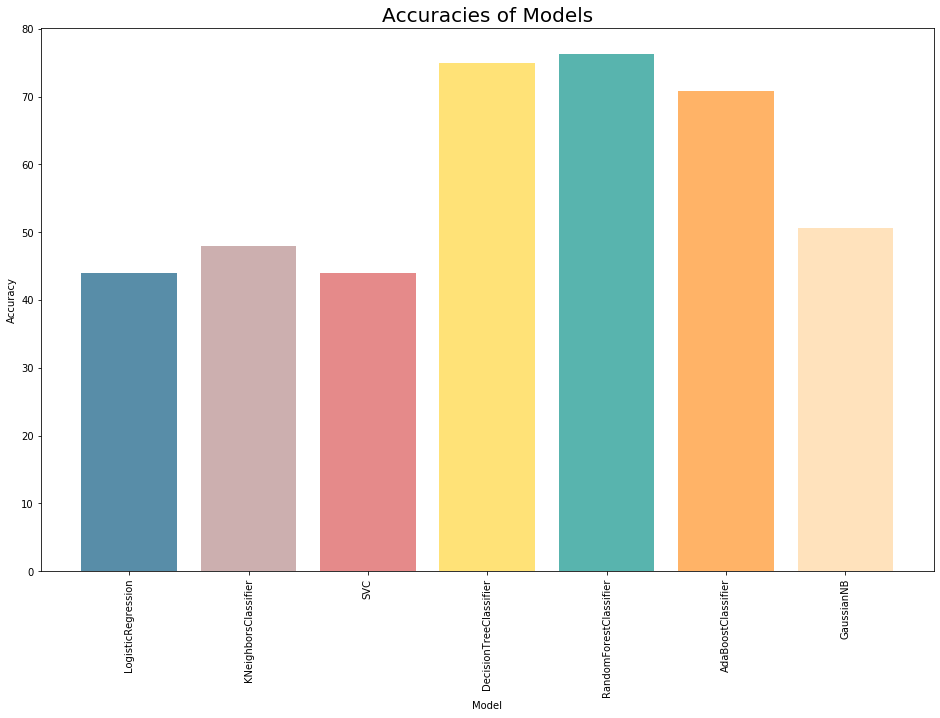

In [13]:
accuracy_trump = predict_accuracy("Donald Trump",df_trump_mod)
accuracy_trump = pd.DataFrame(accuracy_trump)
accuracy_trump=accuracy_trump.rename(columns={accuracy_trump.columns[0]: "Person", accuracy_trump.columns[1]: "Model",accuracy_trump.columns[2]: "Percentage"})
accuracy_trump=accuracy_trump.astype({'Percentage': 'float32'})
accuracy_trump['Percentage']=round(accuracy_trump['Percentage']*100,2) 
accuracy_trump
#Plot the Accuracy of Classifiers in predicting the sentiment of Trump Tweet
Index = accuracy_trump['Model']
Accuracy = accuracy_trump['Percentage']
plt.figure(figsize=(16, 10))
plt.bar(Index,Accuracy,color=['#588da8', '#ccafaf', '#e58a8a','#ffe277', '#58b4ae', '#ffb367', '#ffe2bc'])
plt.xticks(Index, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models', fontdict = {'fontsize' : 20})


<h3>Frequency of words</h3>

Frequently Used Words by Donald Trump in his masked image

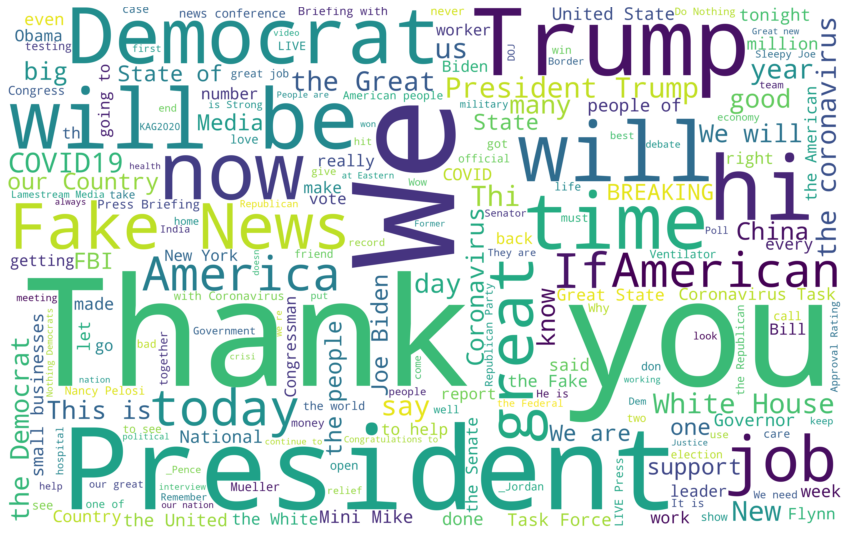

In [14]:
#WordCloud of Tweets
from PIL import Image
#display(Image.open("C:/Users/aisha/Dropbox/CUNY/github/BB_Pics/t1.jpg")) 
mask= np.array(Image.open("C:/Users/aisha/Dropbox/CUNY/github/BB_Pics/t12.jpg"))
stopwords = set(STOPWORDS)
words = " ".join(review for review in df_trump_mod.tweet)
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('&')
                                and not word.startswith('ha')
                                and not word.startswith('wa')
                                and not word.startswith('thi')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',contour_width=1, contour_color='steelblue',
                      width=4000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(15, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

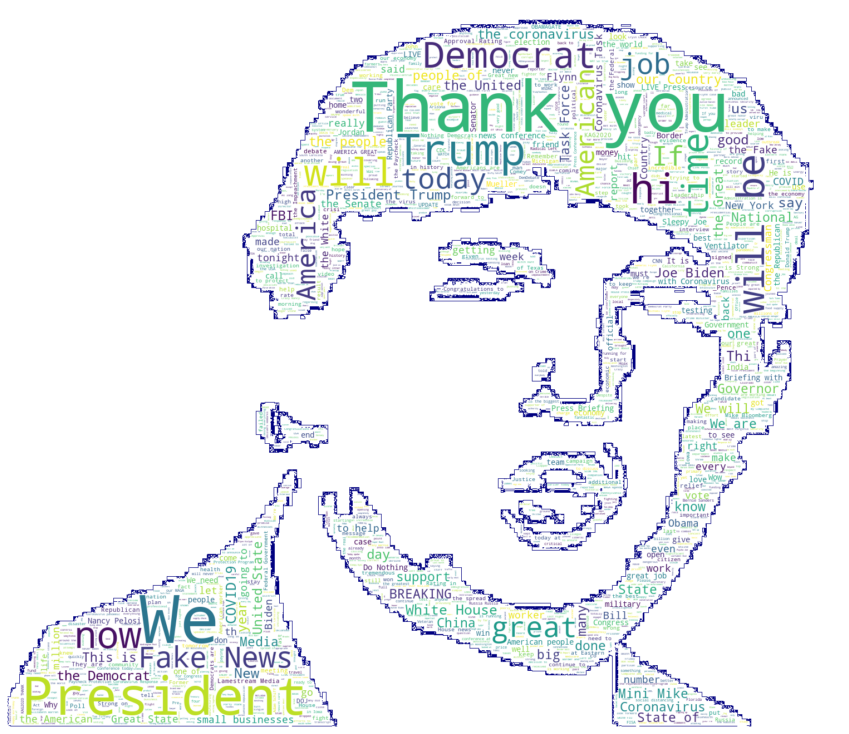

In [15]:
generate_wordcloud(str(cleaned_word), mask)

<h3>Top 20 Words used by Donald Trump</h3>

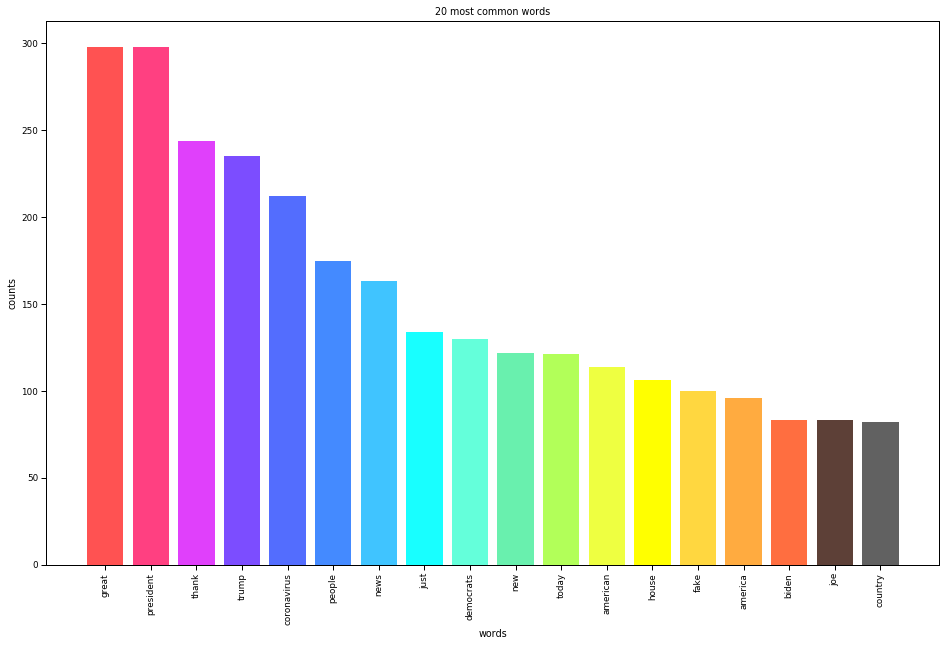

In [30]:
#Find Most common 20 words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df_trump_mod['tweet'])
plot_20_most_common_words(count_data, count_vectorizer)

<h3>Number of Favorite Tweets and Retweets</h3>

In [18]:
#Trend on Week Days with most number of tweets
fav_max = np.max(df_trump['favourite_count'])
rt_max  = np.max(df_trump['retweet_count'])
df_plt_fav = pd.DataFrame(zip(list(df_trump.favourite_count),list(df_trump.created_date)))
fav = df_trump[df_trump.favourite_count == fav_max].index[0]
rt  = df_trump[df_trump.retweet_count == rt_max].index[0]

print("The tweet with more likes is: \n{}".format(df_trump['tweet'][fav]))
print("Number of likes: {}".format(fav_max))

print("The tweet with more retweets is: \n{}".format(df_trump['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))


The tweet with more likes is: 
THE UNITED STATES LOVES ITALY! https://t.co/DESUJ4QM41
Number of likes: 635320
The tweet with more retweets is: 
RT @realDonaldTrump: https://t.co/JDS4zUXXJG
Number of retweets: 128664


<h3>Tweet Trends</h3>

Plotting the tweet trends based on day of week

             Count  Created_Date
day_of_week                     
Friday         504           504
Monday         414           414
Saturday       524           524
Sunday         558           558
Thursday       311           311
Tuesday        479           479
Wednesday      400           400


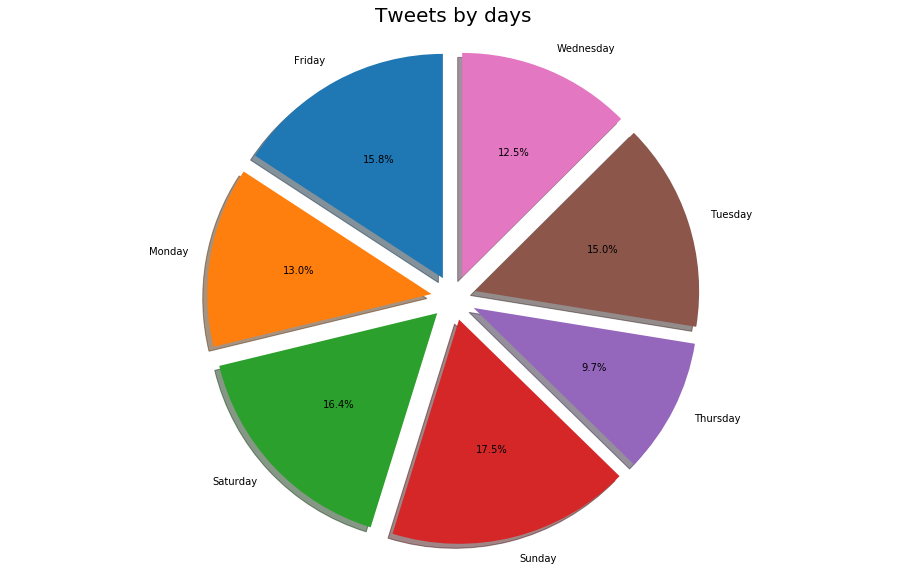

In [19]:
df_plt_fav=df_plt_fav.rename(columns={df_plt_fav.columns[0]: "Count", df_plt_fav.columns[1]: "Created_Date"})
df_plt_fav['Created_Date'] = pd.to_datetime(df_plt_fav['Created_Date'])
df_plt_fav['day_of_week']=df_plt_fav['Created_Date'].dt.day_name()
df_plt = df_plt_fav.groupby(["day_of_week"]).count()
Index=df_plt.index
Count=df_plt.Count
labels=df_plt.index
values=df_plt.Count
explode = [0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1]
plt.figure(figsize=(16, 10))
print(df_plt)
#my_colors1 = ["#ffff00","#ffd740","#ffab40","#ff6e40","#5d4037","#616161","#455a64"]

plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tweets by days', fontdict = {'fontsize' : 20})
plt.show()

<h2>Sentiment Analysis</h2>

Sentiment Analysis has been done using VADER and TEXTBLOB analysis

<h3>Sentiment Analysis by VADER</h3>

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

Text(0.5, 0, 'Mood')

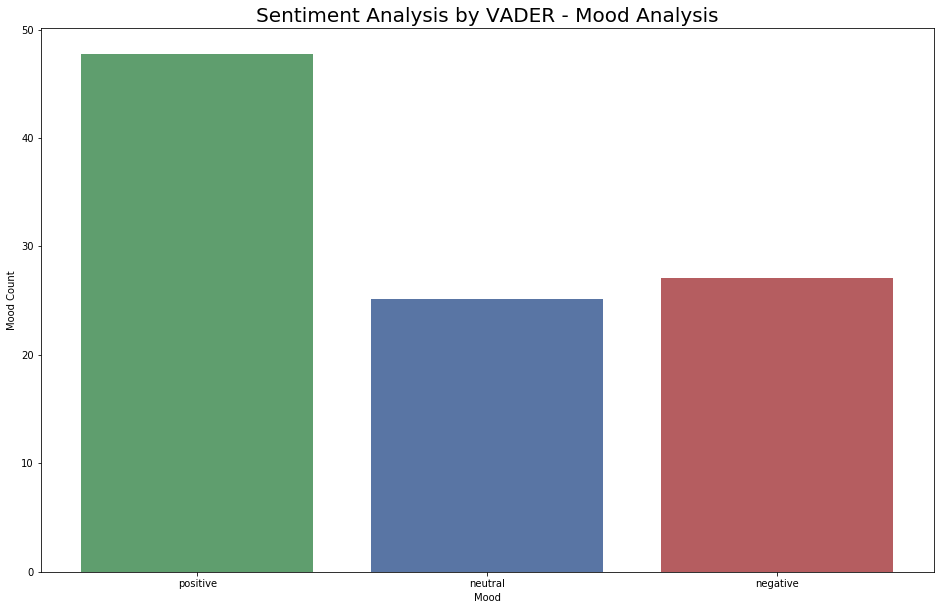

In [20]:
vader_res_trump = vader_sentiment("Donald Trump",df_trump_mod)
vader_res_boris = vader_sentiment("Boris Johnson",df_boris_mod)
vader_res_modi = vader_sentiment("Narendra Modi",df_modi_mod)
vader_res_merkel = vader_sentiment("Angela Merkel",df_merkel_mod)
vader_res_macron = vader_sentiment("Emmanuel Macron",df_macron_mod)
pos_pct=round(float(vader_res_trump[0][2]),2)
neu_pct=round(float(vader_res_trump[1][2]),2)
neg_pct=round(float(vader_res_trump[2][2]),2)
Index = [1,2,3]
tweet_pct = [pos_pct,neu_pct,neg_pct]
plt.figure(figsize=(16, 10))
plt.bar(Index,tweet_pct, color=['#5f9e6e', '#5975a4', '#b55d60'])
plt.xticks(Index,['positive','neutral','negative'])
plt.title('Sentiment Analysis by VADER - Mood Analysis', fontdict = {'fontsize' : 20})
plt.ylabel('Mood Count')
plt.xlabel('Mood')

<h3>Sentiment Analysis by TextBlob</h3>

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [21]:
tblob_res_trump = textblob_sentiment("Donald Trump",df_trump_mod)
tblob_res_macron = textblob_sentiment("Emmanuel Macron",df_macron_mod)
tblob_res_merkel = textblob_sentiment("Angela Merkel",df_merkel_mod)
tblob_res_modi = textblob_sentiment("Narendra Modi",df_modi_mod)
tblob_res_boris = textblob_sentiment("Boris Johnson",df_boris_mod)

Text(0.5, 0, 'Mood')

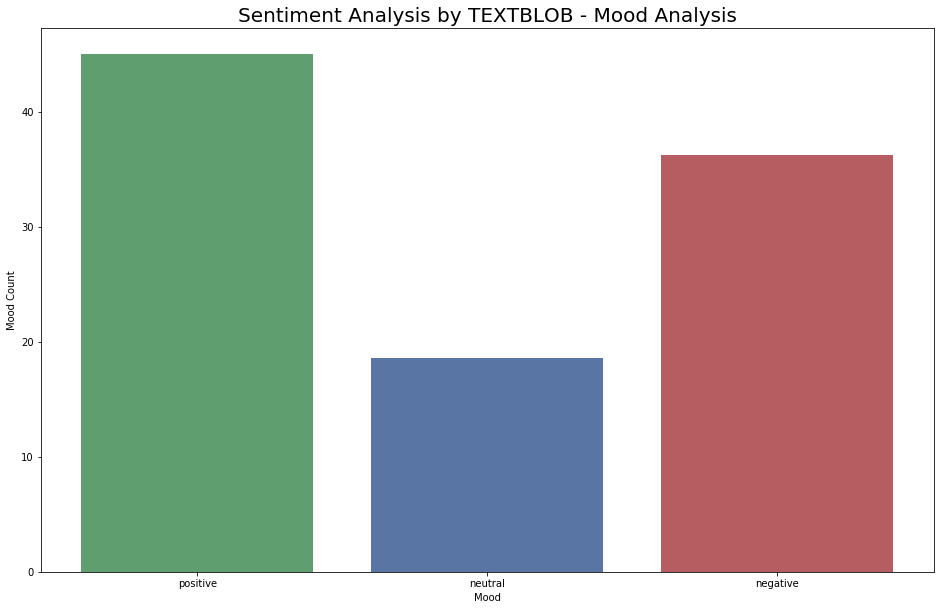

In [22]:
pos_pct=round(float(tblob_res_trump[0][2]),2)
neu_pct=round(float(tblob_res_trump[1][2]),2)
neg_pct=round(float(tblob_res_trump[2][2]),2)
Index = [1,2,3]
tweet_pct = [pos_pct,neu_pct,neg_pct]
plt.figure(figsize=(16, 10))
plt.bar(Index,tweet_pct, color=['#5f9e6e', '#5975a4', '#b55d60'])
plt.title('Sentiment Analysis by TEXTBLOB - Mood Analysis', fontdict = {'fontsize' : 20})
plt.xticks(Index,['positive','neutral','negative'])
plt.ylabel('Mood Count')
plt.xlabel('Mood')

<h3>Leader Sentiment Comparison - TEXTBLOB</h3>

In [23]:
tblob_all_leaders=[]
for item in tblob_res_boris:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_trump:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_macron:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_merkel:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))
for item in tblob_res_modi:
    tblob_all_leaders.append(list([item[0],item[1],item[2]]))

tblob_all_df=pd.DataFrame(tblob_all_leaders)
tblob_all_df.columns = ['Leader', 'Mood','Percentage']
print(tblob_all_df)

             Leader                 Mood          Percentage
0     Boris Johnson  Positive Percentage  53.771820448877804
1     Boris Johnson  Negative Percentage   11.72069825436409
2     Boris Johnson   Neutral Percentage   34.50748129675811
3      Donald Trump  Positive Percentage  45.078369905956116
4      Donald Trump  Negative Percentage   18.58934169278997
5      Donald Trump   Neutral Percentage   36.33228840125392
6   Emmanuel Macron  Positive Percentage  17.835983785469285
7   Emmanuel Macron  Negative Percentage  2.3386342376052385
8   Emmanuel Macron   Neutral Percentage   79.82538197692547
9     Angela Merkel  Positive Percentage  31.691576086956523
10    Angela Merkel  Negative Percentage  20.108695652173914
11    Angela Merkel   Neutral Percentage   48.19972826086956
12    Narendra Modi  Positive Percentage    42.6969791342261
13    Narendra Modi  Negative Percentage   4.827156649018997
14    Narendra Modi   Neutral Percentage   52.47586421675491


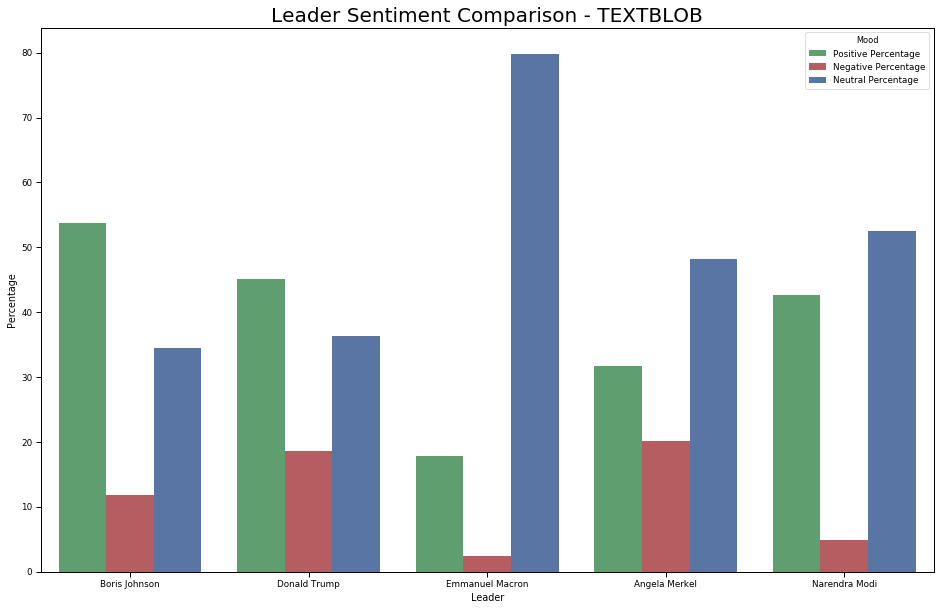

In [24]:
sns.set_context('paper')
plt.figure(figsize=(16, 10))
my_pal = ['#5f9e6e', '#b55d60', '#5975a4']
# create plot
sns.barplot(x = 'Leader', y = 'Percentage', hue = 'Mood', data = tblob_all_df,
            palette = my_pal,
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
plt.title('Leader Sentiment Comparison - TEXTBLOB', fontdict = {'fontsize' : 20})
plt.show()

<h3>Leader Sentiment Comparison - VADER</h3>

             Leader                 Mood          Percentage
0     Boris Johnson  Positive Percentage  58.260598503740646
1     Boris Johnson  Negative Percentage  17.705735660847882
2     Boris Johnson   Neutral Percentage  24.033665835411473
3      Donald Trump  Positive Percentage   47.74294670846395
4      Donald Trump  Negative Percentage  25.203761755485893
5      Donald Trump   Neutral Percentage  27.053291536050157
6   Emmanuel Macron  Positive Percentage   13.78235110695354
7   Emmanuel Macron  Negative Percentage   9.354536950420954
8   Emmanuel Macron   Neutral Percentage   76.86311194262551
9     Angela Merkel  Positive Percentage   36.95652173913044
10    Angela Merkel  Negative Percentage   25.30570652173913
11    Angela Merkel   Neutral Percentage   37.73777173913044
12    Narendra Modi  Positive Percentage   57.98816568047337
13    Narendra Modi  Negative Percentage   4.546870133914668
14    Narendra Modi   Neutral Percentage   37.46496418561196


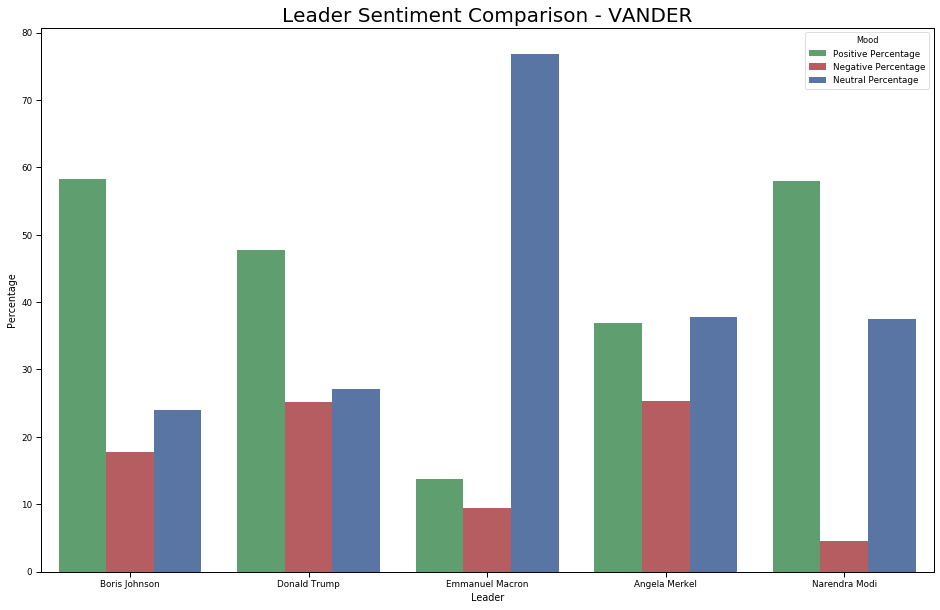

In [25]:
vader_all_leaders=[]
for item in vader_res_boris:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_trump:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_macron:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_merkel:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))
for item in vader_res_modi:
    vader_all_leaders.append(list([item[0],item[1],item[2]]))

vader_all_df=pd.DataFrame(vader_all_leaders)    
vader_all_df
vader_all_df=vader_all_df.rename(columns={vader_all_df.columns[0]: "Leader", vader_all_df.columns[1]: "Mood",vader_all_df.columns[2]: "Percentage"})
print(vader_all_df)

sns.set_context('paper')
plt.figure(figsize=(16, 10))
my_pal = ['#5f9e6e', '#b55d60', '#5975a4']
# create plot
sns.barplot(x = 'Leader', y = 'Percentage', hue = 'Mood', data = vader_all_df,
            palette = my_pal,
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

plt.title('Leader Sentiment Comparison - VANDER', fontdict = {'fontsize' : 20})
plt.show()

<h2>Network Analysis</h2>

The objective is to pick the top 20 targetted tweets and hashtag and build an network model

In [26]:
node=[]
p = re.compile("@[A-Za-z0-9_]+") 
for item in df_trump['tweet']:
    res=p.findall(str(item))
    node.append(p.findall(str(item)))
node
node_str=[]
for item in node:
    for x in item:
        node_str.append(x)
        
node_df = pd.DataFrame(node_str)
node_df.columns = ['target']
node_df.insert(0, 'source', '@realDonaldTrump')
#print(node_df)

pysqldf = lambda q: sqldf(q, globals())
n1 = "select source,target,count(*) as cnt from node_df where target <> '@realDonaldTrump' group by 1,2 order by cnt desc limit 20;"
nx1 = pysqldf(n1)

r1 = "select * from node_df where target in (select target from nx1)"
r2 = pysqldf(r1)
#nx2 = r2[['source','target']]

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 20
Average degree:   1.9048


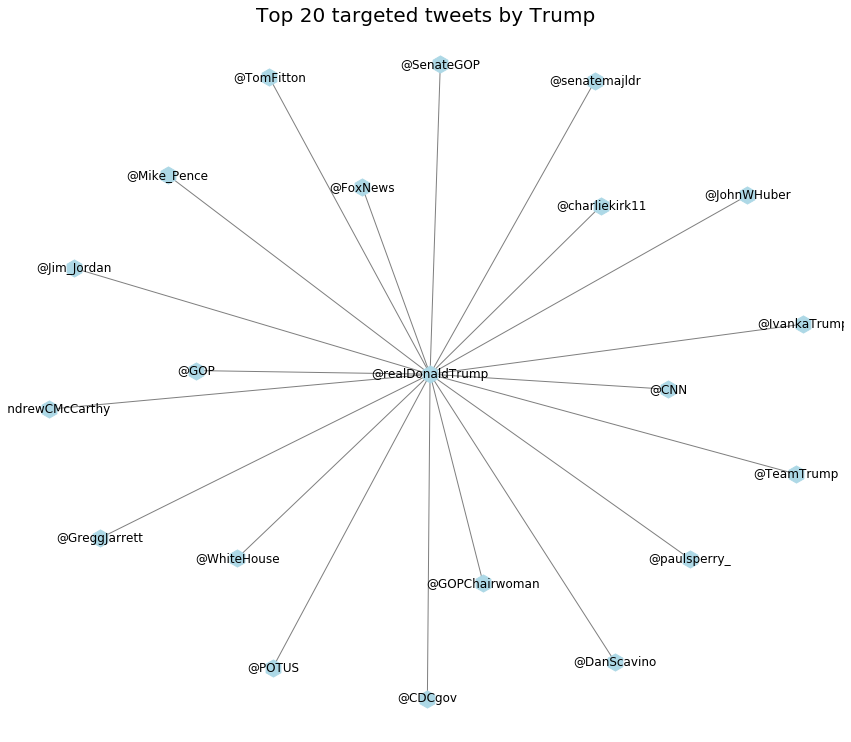

In [27]:
G = nx.from_pandas_edgelist(r2)
print(nx.info(G))
plt.figure(figsize = (15,13))
plt.title("Top 20 targeted tweets by Trump", fontdict = {'fontsize' : 20})
nx.draw_networkx(G, node_color='lightblue',node_shape  = "h",edge_color = "grey")
plt.axis('off')
plt.show(1)

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 20
Average degree:   1.9048


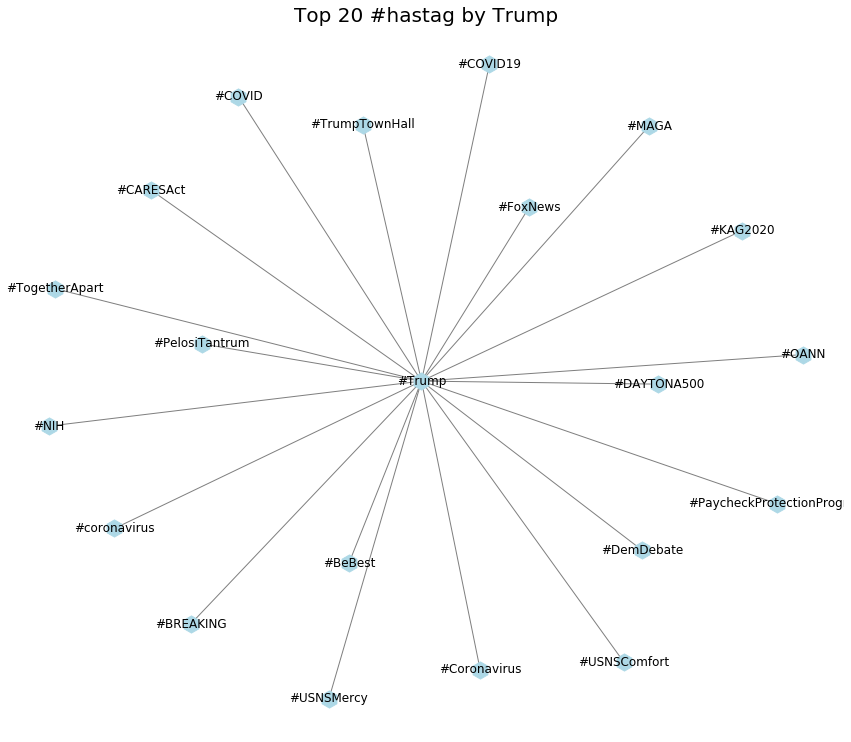

In [28]:
node=[]
p = re.compile("#[A-Za-z0-9_]+") 
for item in df_trump['tweet']:
    res=p.findall(str(item))
    node.append(p.findall(str(item)))
node
node_str=[]
for item in node:
    for x in item:
        node_str.append(x)
        
node_df1 = pd.DataFrame(node_str)

node_df1.columns = ['target']
node_df1.insert(0, 'source', '#Trump')

pysqldf = lambda q1: sqldf(q1, globals())

n01 = "select source,target,count(*) as cnt from node_df1 where target <> '@realDonaldTrump' group by 1,2 order by cnt desc limit 20;"
nx01 = pysqldf(n01)
nx02 = nx01[['source','target']]

#print(nx02)
G1 = nx.from_pandas_edgelist(nx02)
print(nx.info(G1))
plt.figure(figsize = (15,13))
plt.title("Top 20 #hastag by Trump", fontdict = {'fontsize' : 20})
nx.draw_networkx(G1, node_color='lightblue',node_shape  = "h",edge_color = "grey")
plt.axis('off')
plt.show(1)


<h3>Conclusion</h3>
<ol>
  <li>Random Forest Model Classifier performed better on predicting the trump sentiments</li>
    <li>There is an marginal difference between VADER and TEXTBLOB</li>
    <li>Boris Johnson,Donald Trump and Narendra Modi are mostly postive</li>
    <li>Donald Trump and Angela Merkel are top 2 postion in negative tweets</li>
    <li>Based on Network Analysis, Trump targetted Media and fedral associates</li>
    <li>In the recent times, Trump tweets are mostly words to Medical and Political hastags</li>
</ol>